## Introduction
In this kernel, I'd like to share the approach using 1D Convolutional Neural Networks(1D CNN). 1D CNN is sometimes effective to analyze time series data. This kernel introduces U-Net architecture with 1D CNN.

## Import Library

In [1]:
import os, time, math, glob
from functools import partial

from scipy import stats
import numpy as np
import pandas as pd

from sklearn.metrics import cohen_kappa_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.model_selection import KFold, StratifiedKFold, GroupKFold, train_test_split
from sklearn import tree, linear_model

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import Callback
from tensorflow.keras.utils import to_categorical, get_custom_objects

import seaborn as sns
import matplotlib.pyplot as plt

import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots

K = tf.keras.backend
L = tf.keras.layers
AUTO = tf.data.experimental.AUTOTUNE

## Load and Split Dataset
Simply split the input data into certain length.

In [2]:
SEED = 42
seq_len = 2500
batch_size = 32

add_feature = True
use_cv = False

ori_data_dir = '../input/liverpool-ion-switching/'
data_dir = '../input/ion-clean/'

# train = pd.read_csv("../input/liverpool-ion-switching/train.csv")
# test = pd.read_csv("../input/liverpool-ion-switching/test.csv")

train2 = pd.read_csv(data_dir + 'train_full_clean.csv')
test2 = pd.read_csv(data_dir + 'test_full_clean.csv')

np.random.seed(SEED)
tf.random.set_seed(SEED)

## Define Model

In [3]:
def mish(x):
    return L.Lambda(lambda x: x * K.tanh(K.softplus(x)))(x)
 
get_custom_objects().update({'mish': L.Activation(mish)})
act_fn = 'mish'  # 'relu' or tf.keras.activations.swish

def conv_bn(x, out_dim, kernel_size, stride=1, dilation=1):
    x = L.Conv1D(out_dim, kernel_size=kernel_size, dilation_rate=dilation, strides=stride, padding="same")(x)
    x = L.BatchNormalization()(x)
    return x

def se_block(x, out_dim):
    shortcut = x
    x = L.GlobalAveragePooling1D()(x)
    x = L.Dense(out_dim//8, activation=act_fn)(x)
    x = L.Dense(out_dim, activation="sigmoid")(x)
    x_out = L.Multiply()([shortcut, x])
    return x_out

def resblock(x, out_dim, kernel_size, dilation=1, use_se=True):
    shortcut = x
    x = cbr(x, out_dim, kernel_size, dilation=dilation)
    x = L.Activation(act_fn)(x)
    x = cbr(x, out_dim, kernel_size, dilation=dilation)
    if use_se:
        x = se_block(x, out_dim)
    x = L.Add()([shortcut, x])
    x = L.Activation(act_fn)(x)
    return x

def wave_block(x, out_dim, num_layers, kernel_size=3):
    dilation_rates = [2**i for i in range(num_layers)]
    x = L.Conv1D(filters=out_dim,
                 kernel_size=1,
                 padding='same')(x)
    shortcut = x
    for d_rate in dilation_rates:
        act_out = L.Conv1D(filters=out_dim,
                            kernel_size=kernel_size,
                            padding='same',
                            activation='mish',
                            dilation_rate=d_rate)(x)
        gating = L.Conv1D(filters=out_dim,
                            kernel_size=kernel_size,
                            padding='same',
                            activation='sigmoid',
                            dilation_rate=d_rate)(x)
        x = L.Multiply()([act_out, gating])
        x = L.Conv1D(filters=out_dim,
                     kernel_size=1,
                     padding='same')(x)
        shortcut = L.Add()([shortcut, x])
    return shortcut

def build_net(num_class, input_shape=(None,1)):
    hidden_dim = 16
    stacked_layers = [12, 8, 4, 1]
    
    inp = L.Input(input_shape)
    x = inp
    for k, num_layers in enumerate(stacked_layers):
        x = L.GaussianNoise(0.01)(x)
        x = wave_block(x, 2**k*hidden_dim, num_layers)
    
    # regressor
    #x = Conv1D(1, kernel_size=kernel_size, strides=1, padding="same")(x)
    #x = Activation("sigmoid")(x)
    #out = Lambda(lambda x: 12*x)(x)
    
    # classifier
    x = L.Conv1D(num_class, kernel_size=1, strides=1, padding="same")(x)
    out = L.Activation("softmax")(x)
    
    model = Model(inp, out)
    return model

def macro_f1(y_true, y_pred):
    f1_score_macro = partial(f1_score, average='macro')
    y_true = tf.reshape(tf.math.argmax(y_true, axis=-1), [-1])
    y_pred = tf.reshape(tf.math.argmax(y_pred, axis=-1), [-1])
    return tf.py_function(f1_score_macro, (y_true, y_pred), tf.double)

class MacroF1(Callback):
    def __init__(self, model, inputs, targets):
        self.model = model
        self.inputs = inputs
        self.targets = np.argmax(targets, axis=2).reshape(-1)
        self.score_list = []

    def on_epoch_end(self, epoch, logs):
        pred = np.argmax(self.model.predict(self.inputs), axis=2).reshape(-1)
        score = f1_score(self.targets, pred, average="macro")
        self.score_list.append(score)
        print(f'val_macro_f1_score:: {score:.5f}')

def train_val_split(x, y):
    kf = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)
    cv_indices = list(kf.split(x, y))
    return cv_indices

## Training

In [4]:
def cast_label_type(x, y):
    return x, tf.cast(y, tf.float32)

def data_augment(x, y):
    rand_num = tf.random.uniform([1], minval=0, maxval=1, dtype='float32')
    # flip
    if rand_num < 0.5:    
        x = x[::-1]
        y = y[::-1]
    return x, y

def get_training_dataset(x, y):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    return (
        dataset
        .map(cast_label_type, num_parallel_calls=AUTO)
        .map(data_augment, num_parallel_calls=AUTO)
        .repeat()
        .shuffle(4096)
        .batch(batch_size)
        .prefetch(AUTO)
    )

def get_validation_dataset(x, y):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    return (
        dataset
        .map(cast_label_type, num_parallel_calls=AUTO)
        .batch(batch_size)
        .prefetch(AUTO)
    )

def add_category(train, test):
    # treat 10 open channels group as another category
    
    train["category"] = 0
    test["category"] = 0
    
    # train segments with more then 9 open channels classes
    train.loc[2_000_000:2_500_000, 'category'] = 1
    train.loc[4_500_000:5_000_000, 'category'] = 1
    
    # test segments with more then 9 open channels classes (potentially)
    test.loc[500_000:600_000, "category"] = 1
    test.loc[700_000:800_000, "category"] = 1
    
    train['category'] = train['category'].astype( np.float32 )
    test['category'] = test['category'].astype( np.float32 )
    
    return train, test

def add_shift_features(df, steps=(1,2,3)):
    steps = np.asarray(steps, dtype=np.int32)
    steps = np.append(steps, -steps)
    for step in steps:
        df['signal_shift_' + str(step)] = df['signal'].shift(step, fill_value=0)
    df['signal_2'] = df['signal'] ** 2
    return df

def augment_data(df):
    aug_df = df[df["group"] == 5].copy()
    aug_df["category"] = 1
    aug_df["group"] = 10
    for col in ["signal", "open_channels"]:
        aug_df[col] += df[df["group"] == 8][col].values

    aug_df['category'] = aug_df['category'].astype( np.float32 )
    df = df.append(aug_df, sort=False)
    return df

In [5]:
train2["group"] = np.arange(train2.shape[0]) // 500_000

train2, test2 = add_category(train2, test2)
train2 = augment_data(train2)  # add one additional batch
num_batches = train2.shape[0] // 500_000

In [6]:
def lr_schedule_function(LR):
    def lrs(epoch):
        if epoch < 40:
            lr = LR
        elif epoch < 50:
            lr = LR / 3
        elif epoch < 60:
            lr = LR / 6
        elif epoch < 75:
            lr = LR / 9
        elif epoch < 85:
            lr = LR / 12
        elif epoch < 100:
            lr = LR / 15
        else:
            lr = LR / 50
        return lr
    return lrs


class OneCycleLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    ref: http://arxiv.org/abs/1803.09820
    - Example
        ```python
            clr = OneCycleLR(num_iters=10000, max_lr=0.003)
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    - Arguments
        num_iters: number of iterations of the whole training process.
        max_lr: upper bound of lr in the cycle.
        moms: upper and lower bounds of momentum in the cycle
        div_factor: init_lr = max_lr / div_factor.
        sep_ratio: ratio of iterations to segment the cycle.
        final_div: final_lr = max_lr / final_div.
    """

    def __init__(self, num_iters, max_lr=0.003, moms=(.95, .85), sched_profile='cosine',
                 cycle_momentum=True, div_factor=40, sep_ratio=0.3, final_div=None):
        super(OneCycleLR, self).__init__()

        self.max_lr = max_lr
        self.init_lr = max_lr/div_factor
        if final_div is None: final_div = div_factor*1e4
        self.final_lr = max_lr / final_div
        self.moms = moms
        
        self.sched_profile = sched_profile
        self.cycle_momentum = cycle_momentum

        self.up_iteration = int(num_iters * sep_ratio)
        self.down_iteration = num_iters - self.up_iteration

        self.curr_iter = 0
        self.history = {}

    def _annealing_linear(self, start, end, pct):
        return start + pct * (end-start)
    
    def _annealing_cos(self, start, end, pct):
        cos_out = np.cos(np.pi * pct) + 1
        return end + (start-end)/2 * cos_out

    def step(self):
        if self.sched_profile == 'linear':
            anneal_fcn = self._annealing_linear
        elif self.sched_profile == 'cosine':
            anneal_fcn = self._annealing_cos
        if self.curr_iter <= self.up_iteration:
            pct = self.curr_iter / self.up_iteration
            curr_lr = anneal_fcn(self.init_lr, self.max_lr, pct)
            if self.cycle_momentum:
                curr_mom = anneal_fcn(self.moms[0], self.moms[1], pct)
        else:
            pct = (self.curr_iter-self.up_iteration) / self.down_iteration
            curr_lr = anneal_fcn(self.max_lr, self.final_lr, pct)
            if self.cycle_momentum:
                curr_mom = anneal_fcn(self.moms[1], self.moms[0], pct)
        return curr_lr, curr_mom

    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.curr_iter == 0:
            K.set_value(self.model.optimizer.lr, self.init_lr)
            K.set_value(self.model.optimizer.beta_1, self.moms[0])
        else:
            curr_lr, curr_mom = self.step()
            K.set_value(self.model.optimizer.lr, curr_lr)
            K.set_value(self.model.optimizer.beta_1, curr_mom)

    def on_batch_end(self, epoch, logs=None):
        logs = logs or {}
        self.curr_iter += 1

        self.history.setdefault('lr', []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault('iterations', []).append(self.curr_iter)
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        curr_lr, curr_mom = self.step()
        K.set_value(self.model.optimizer.lr, curr_lr)
        K.set_value(self.model.optimizer.beta_1, curr_mom)

In [7]:
def run_training(num_class, param_dict, checkpoint_name, add_feat=False, is_cv=False):
    
    x_mean = train2.signal.values.mean()
    x_sigma = train2.signal.values.std()
    train2.signal = (train2.signal - x_mean) / x_sigma
    
    if not add_feat:
        train_inp = train2.signal.values.reshape(-1, seq_len, 1)
    else:
        train_feat = add_shift_features(train2, range(1,4))
        feature_cols = [c for c in train_feat.columns if c not in ("open_channels", "time", "group")]
        train_inp = train_feat[feature_cols].values.reshape(-1, seq_len, len(feature_cols))
        
    train_tar = train2.open_channels.values
    train_tar = to_categorical(train_tar).reshape(-1, seq_len, num_class)
    
    num_per_batch = train_inp.shape[0] // num_batches  # 10+1 batches of time series
    group_ids = np.concatenate([[i]*num_per_batch for i in range(num_batches)])
    cv_indices = train_val_split(range(train_inp.shape[0]), group_ids)
    
    learning_rate = param_dict['learning_rate']
    n_epoch = param_dict['n_epoch']
    
    if not is_cv:
        trn_idx, val_idx = cv_indices[0]
        x_train = train_inp[trn_idx]
        y_train = train_tar[trn_idx]
        x_val = train_inp[val_idx]
        y_val = train_tar[val_idx]
        steps_per_epoch = math.ceil(x_train.shape[0] / batch_size)
        
        if not add_feat:
            model = build_net(num_class)
        else:
            model = build_net(num_class, input_shape=(None, len(feature_cols)))
        model.compile(optimizer=tf.keras.optimizers.Adam(lr=learning_rate),
                      loss=tf.keras.losses.CategoricalCrossentropy(),
                      metrics=["accuracy", macro_f1])
        lr_schedule = OneCycleLR(steps_per_epoch*n_epoch, max_lr=learning_rate)
#         lr_schedule = tf.keras.callbacks.LearningRateScheduler(lr_schedule_function(learning_rate))
        cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_name+'.h5', monitor='val_loss', mode='min',
                                                         save_best_only=True, save_weights_only=True, verbose=1)
        f1_callback = MacroF1(model, x_val, y_val)
        log = model.fit(
            get_training_dataset(x_train, y_train),
            validation_data=get_validation_dataset(x_val, y_val),
            epochs=n_epoch,
            steps_per_epoch=steps_per_epoch,
            verbose=2,
            callbacks=[
                lr_schedule,
                cp_callback,
                f1_callback
            ]
        )
        model.load_weights(checkpoint_name+'.h5')
        pred = np.argmax(model.predict(x_val), axis=-1).reshape(-1)
        pred_tta = np.argmax( (model.predict(x_val) + model.predict(x_val[:,::-1,:])[:,::-1,:]) / 2 , axis=-1).reshape(-1)
        gt = np.argmax(y_val, axis=-1).reshape(-1)
        print()
        print("val f1 score: ", f1_score(gt, pred, average="macro"))
        print("val f1 score (tta): ", f1_score(gt, pred_tta, average="macro"))
        
        fig = make_subplots(rows=2, cols=1)
        fig.add_trace(
            go.Scatter(x=np.arange(n_epoch),
                       y=log.history['loss'],
                       mode='lines',
                       name='Train loss'),
            row=1, col=1
        )
        fig.add_trace(
            go.Scatter(x=np.arange(n_epoch),
                       y=log.history['val_loss'],
                       mode='lines',
                       name='Valid loss'),
            row=1, col=1
        )
        fig.add_trace(
            go.Scatter(x=np.arange(n_epoch),
                       y=log.history['macro_f1'],
                       mode='lines',
                       name='Train f1'),
            row=2, col=1
        )
        fig.add_trace(
            go.Scatter(x=np.arange(n_epoch),
                       y=f1_callback.score_list,
                       mode='lines',
                       name='Valid f1'),
            row=2, col=1
        )
        fig.show()
    
    else:
        oof_y = []
        oof_p = []
        oof_pt = []
        for i in range(5):
            print(f"Fold {i+1}:")
            
            trn_idx, val_idx = cv_indices[i]
            x_train = train_inp[trn_idx]
            y_train = train_tar[trn_idx]
            x_val = train_inp[val_idx]
            y_val = train_tar[val_idx]
            steps_per_epoch = math.ceil(x_train.shape[0] / batch_size)
            
            if not add_feat:
                model = build_net(num_class)
            else:
                model = build_net(num_class, input_shape=(None, len(feature_cols)))
            model.compile(optimizer=Adam(lr=learning_rate),
                          loss=tf.keras.losses.CategoricalCrossentropy(),
                          metrics=["accuracy", macro_f1])
            lr_schedule = OneCycleLR(steps_per_epoch*n_epoch, max_lr=learning_rate)
#             lr_schedule = tf.keras.callbacks.LearningRateScheduler(lr_schedule_function(learning_rate))
            cp_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_name+f'_{i}.h5', monitor='val_loss', mode='min',
                                                             save_best_only=True, save_weights_only=True, verbose=1)
            f1_callback = MacroF1(model, x_val, y_val)
            model.fit(
                get_training_dataset(x_train, y_train),
                validation_data=get_validation_dataset(x_val, y_val),
                epochs=n_epoch,
                steps_per_epoch=steps_per_epoch,
                verbose=2,
                callbacks=[
                    lr_schedule,
                    cp_callback,
                    f1_callback
                ]
            )
            model.load_weights(checkpoint_name+f'_{i}.h5')
            pred = np.argmax(model.predict(x_val), axis=-1).reshape(-1)
            pred_tta = np.argmax( (model.predict(x_val) + model.predict(x_val[:,::-1,:])[:,::-1,:]) / 2 , axis=-1).reshape(-1)
            gt = np.argmax(y_val, axis=-1).reshape(-1)
            print()
            print("val f1 score: ", f1_score(gt, pred, average="macro"))
            print("val f1 score (tta): ", f1_score(gt, pred_tta, average="macro"))
            K.clear_session()

            oof_y.append(gt)
            oof_p.append(pred)
            oof_pt.append(pred_tta)
            print()
        oof_y = np.concatenate(oof_y)
        oof_p = np.concatenate(oof_p)
        oof_pt = np.concatenate(oof_pt)
        print("OOF val f1 score: ", f1_score(oof_y, oof_p, average="macro"))
        print("OOF val f1 score (tta): ", f1_score(oof_y, oof_pt, average="macro"))
        print()
    
    return x_mean, x_sigma

In [8]:
param_dict = {'learning_rate':1.5e-3, 'n_epoch':60}
x_mean, x_sigma = run_training(11, param_dict, 'best_model', add_feat=add_feature, is_cv=use_cv)

Epoch 1/60

Epoch 00001: val_loss improved from inf to 1.51065, saving model to best_model.h5
val_macro_f1_score:: 0.18839
55/55 - 16s - loss: 1.8590 - accuracy: 0.2778 - macro_f1: 0.1307 - val_loss: 1.5106 - val_accuracy: 0.3546 - val_macro_f1: 0.1876
Epoch 2/60

Epoch 00002: val_loss improved from 1.51065 to 1.08803, saving model to best_model.h5
val_macro_f1_score:: 0.42670
55/55 - 13s - loss: 1.2973 - accuracy: 0.5311 - macro_f1: 0.3175 - val_loss: 1.0880 - val_accuracy: 0.6275 - val_macro_f1: 0.4701
Epoch 3/60

Epoch 00003: val_loss improved from 1.08803 to 0.57967, saving model to best_model.h5
val_macro_f1_score:: 0.68243
55/55 - 13s - loss: 0.8098 - accuracy: 0.7101 - macro_f1: 0.5635 - val_loss: 0.5797 - val_accuracy: 0.7631 - val_macro_f1: 0.6362
Epoch 4/60

Epoch 00004: val_loss improved from 0.57967 to 0.43991, saving model to best_model.h5
val_macro_f1_score:: 0.78794
55/55 - 13s - loss: 0.5095 - accuracy: 0.7945 - macro_f1: 0.7325 - val_loss: 0.4399 - val_accuracy: 0.8268

## Predict and Submit


In [9]:
sub_0 = pd.read_csv(ori_data_dir + 'sample_submission.csv')
sub_1 = pd.read_csv(ori_data_dir + 'sample_submission.csv')
sub_2 = pd.read_csv(ori_data_dir + 'sample_submission.csv')
sub_3 = pd.read_csv(ori_data_dir + 'sample_submission.csv')
sub_4 = pd.read_csv(ori_data_dir + 'sample_submission.csv')
subs = [sub_0, sub_1, sub_2, sub_3, sub_4]

sub = pd.read_csv(ori_data_dir + 'sample_submission.csv')
sub_tta = pd.read_csv(ori_data_dir + 'sample_submission.csv')

sub_m = pd.read_csv(ori_data_dir + 'sample_submission.csv')
sub_m_tta = pd.read_csv(ori_data_dir + 'sample_submission.csv')

In [10]:
def test_inference(num_class, x_mean, x_sigma, checkpoint_name, add_feat=False, is_cv=False):
    test2.signal = (test2.signal - x_mean) / x_sigma
    if not add_feat:
        x_test = test2.signal.values.reshape(-1, seq_len, 1)
        model = build_net(num_class)
    else:
        test_feat = add_shift_features(test2, range(1,4))
        feature_cols = [c for c in test_feat.columns if c not in ("open_channels", "time", "group")]
        x_test = test_feat[feature_cols].values.reshape(-1, seq_len, len(feature_cols))
        model = build_net(num_class, input_shape=(None, len(feature_cols)))
    
    if not is_cv:
        model.load_weights(checkpoint_name + '.h5')
        p_test = model.predict(x_test)
        p_test_tta = (model.predict(x_test) + model.predict(x_test[:,::-1,:])[:,::-1,:]) / 2
    else:
        p_test = p_test_tta = 0
        p_test_m = p_test_m_tta = 0
        for i, sub_df in enumerate(subs):
            model.load_weights(checkpoint_name + f'_{i}.h5')
            prob = model.predict(x_test)
            prob_inv = model.predict(x_test[:,::-1,:])[:,::-1,:]
            sub_df.open_channels = np.argmax(prob, axis=-1).reshape(-1)
            sub_df.to_csv(f"submission_{i}.csv", index=False, float_format='%.4f')
            
            p_test += prob / 5
            p_test_tta += ((prob + prob_inv) / 2) / 5
            p_test_m += np.argmax(prob, axis=-1) / 5
            p_test_m_tta += ((np.argmax(prob, axis=-1) + np.argmax(prob_inv, axis=-1)) / 2) / 5
            
        sub_m.open_channels = np.round(p_test_m).astype(np.int32).reshape(-1)
        sub_m_tta.open_channels = np.round(p_test_m_tta).astype(np.int32).reshape(-1)
        sub_m.to_csv("submission_mode.csv", index=False, float_format='%.4f')
        sub_m_tta.to_csv("submission_mode_tta.csv", index=False, float_format='%.4f')
    
    sub.open_channels = np.argmax(p_test, axis=-1).reshape(-1)
    sub_tta.open_channels = np.argmax(p_test_tta, axis=-1).reshape(-1)
    sub.to_csv("submission.csv", index=False, float_format='%.4f')
    sub_tta.to_csv("submission_tta.csv", index=False, float_format='%.4f')

In [11]:
test_inference(11, x_mean, x_sigma, 'best_model', add_feat=add_feature, is_cv=use_cv)

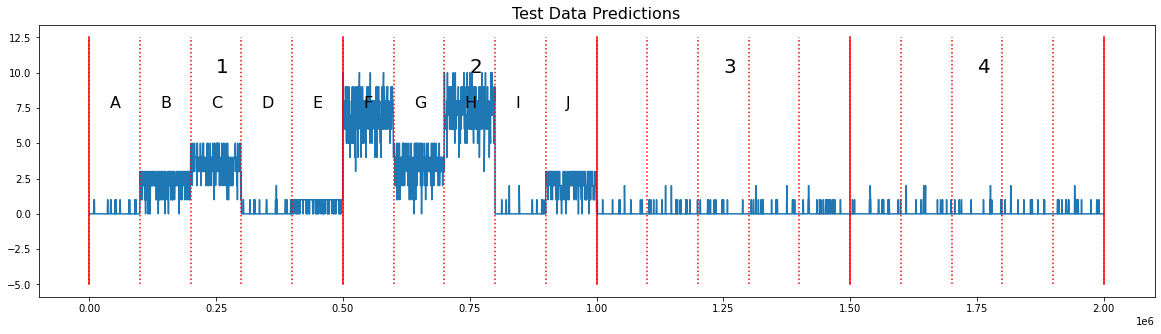

In [12]:
plt.figure(figsize=(20,5))
res = 500; let = ['A','B','C','D','E','F','G','H','I','J']
plt.plot(range(0, sub.shape[0], res), sub.open_channels[0::res])
for i in range(5): plt.plot([i*500000,i*500000], [-5,12.5], 'r')
for i in range(21): plt.plot([i*100000,i*100000], [-5,12.5], 'r:')
for k in range(4): plt.text(k*500000+250000, 10, str(k+1), size=20)
for k in range(10): plt.text(k*100000+40000, 7.5, let[k], size=16)
plt.title('Test Data Predictions', size=16)
plt.show()

## Inference test

In [13]:
# orig_signal = train2.signal.values.reshape(-1, seq_len, 1)

# x_mean = train2.signal.values.mean()
# x_sigma = train2.signal.values.std()
# train2.signal = (train2.signal - x_mean) / x_sigma

# train_tar = train2.open_channels.values.reshape(-1, seq_len, 1)
# if not add_feature:
#     train_inp = train2.signal.values.reshape(-1, seq_len, 1)
# else:
#     train_feat = add_shift_features(train2, range(1,4))
#     feature_cols = [c for c in train_feat.columns if c not in ("open_channels", "time", "group")]
#     train_inp = train_feat[feature_cols].values.reshape(-1, seq_len, len(feature_cols))

# if not add_feature:
#     model = build_net(11)
# else:
#     model = build_net(11, input_shape=(None, len(feature_cols)))
# model.load_weights('best_model.h5')

# train_inp.shape, train_tar.shape

In [14]:
# def predict_batch(batch_id):
#     raw = orig_signal[125*batch_id:(125+1)*batch_id].reshape(-1)
    
#     probs = model.predict(train_inp[125*batch_id:(125+1)*batch_id])
#     preds = np.argmax(probs, axis=-1).reshape(-1)
#     labels = train_tar[125*batch_id:(125+1)*batch_id].reshape(-1)
    
#     # sanity check
#     print(f1_score(labels, preds, average="macro"))
#     print()
    
#     return raw, labels, preds

# def display_signal(signal):
#     res = 10
#     plt.figure(figsize=(12,5))
#     plt.plot(np.arange(0,len(signal),res)/1e4, signal[0::res], 'k')
#     plt.xlabel('Time (s)')
#     plt.ylabel('Current (pA)')
#     plt.legend('Raw current', loc='lower left')

# def display_gt_pred(labels, preds):
#     res = 10
#     plt.subplots(figsize=(12,10))

#     ax = plt.subplot(211)
#     ax.plot(np.arange(0,len(labels),res)/1e4, labels[0::res])
#     ax.set_title('GT vs prediction')
#     ax.set_ylabel('No. Open Channels')
#     ax.legend(['Ground truth'], loc='lower left')

#     ax = plt.subplot(212)
#     ax.plot(np.arange(0,len(labels),res)/1e4, preds[0::res], 'r')
#     ax.set_xlabel('Time (s)')
#     ax.set_ylabel('No. Open Channels')
#     ax.legend(['Model'], loc='lower left')

In [15]:
# %%time

# batch_id = 3
# raw, labels, preds = predict_batch(batch_id)

In [16]:
# a = 5000
# b = a + 5000
# display_signal(raw[a:b])
# display_gt_pred(labels[a:b], preds[a:b])

In [17]:
# %%time

# batch_id = 5
# raw, labels, preds = predict_batch(batch_id)

In [18]:
# a = 5000
# b = a + 5000
# display_signal(raw[a:b])
# display_gt_pred(labels[a:b], preds[a:b])